In [ ]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT']='COMPRESSED'

In [ ]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
content_path = r"C:\Users\SAVISAMI\Downloads\content image 2.jpg"
style_path1 = r"C:\Users\SAVISAMI\Downloads\style image 2.jpg"
style_path2 = r"C:\Users\SAVISAMI\Downloads\style image2.jpg"
style_path3 = r"C:\Users\SAVISAMI\Downloads\style image 1.jpg"



In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [ ]:
from google.colab import files
from IPython.display import Image


In [ ]:
uploaded=files.upload()

Saving content image 2.jpg to content image 2 (1).jpg


In [ ]:
uploaded=files.upload()

Saving style image 1.jpg to style image 1 (1).jpg


In [ ]:
uploaded=files.upload()

Saving style image 2.jpg to style image 2.jpg


In [ ]:
uploaded=files.upload()

Saving style image2.jpg to style image2 (1).jpg


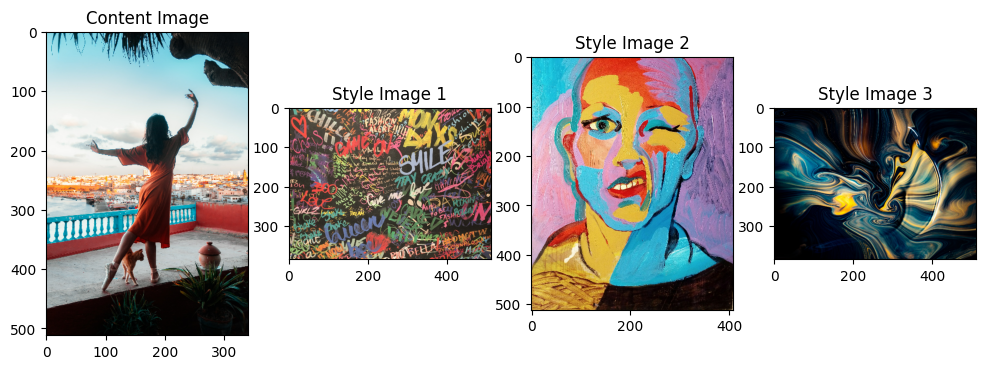

In [ ]:
content_image = load_img('content image 2.jpg')
style_image1 = load_img('style image 1.jpg')  # Load the first style image
style_image2 = load_img('style image 2.jpg')  # Load the second style image
style_image3 = load_img('style image2.jpg')  # Load the third style image


plt.subplot(1, 4, 1)  # Adjust the subplot to accommodate four images
imshow(content_image, 'Content Image')

plt.subplot(1, 4, 2)  # Display the first style image
imshow(style_image1, 'Style Image 1')

plt.subplot(1, 4, 3)  # Display the second style image
imshow(style_image2, 'Style Image 2')

plt.subplot(1, 4, 4)  # Display the third style image
imshow(style_image3, 'Style Image 3')

plt.show()  # Show the plot


In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574710816/574710816 [==============================] - 6s 0us/step


TensorShape([1, 1000])

In [ ]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

35363/35363 [==============================] - 0s 0us/step


[('water_buffalo', 0.15611123),
 ('seashore', 0.066819824),
 ('ox', 0.038705796),
 ('lakeside', 0.029735845),
 ('sandbar', 0.026938098)]

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80134624/80134624 [==============================] - 1s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image1*255)
style_outputs = style_extractor(style_image2*255)
style_outputs = style_extractor(style_image3*255)
#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 384, 512, 64)
  min:  0.0
  max:  837.0105
  mean:  17.645317

block2_conv1
  shape:  (1, 192, 256, 128)
  min:  0.0
  max:  4660.427
  mean:  109.9978

block3_conv1
  shape:  (1, 96, 128, 256)
  min:  0.0
  max:  6973.974
  mean:  138.30551

block4_conv1
  shape:  (1, 48, 64, 512)
  min:  0.0
  max:  16110.359
  mean:  504.44034

block5_conv1
  shape:  (1, 24, 32, 512)
  min:  0.0
  max:  2558.56
  mean:  49.764996



In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.035370573
    max:  55885.29
    mean:  759.5222

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  170426.84
    mean:  22760.49

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  541982.8
    mean:  26117.574

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  6318114.5
    mean:  336125.38

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  128380.79
    mean:  2998.5906

Contents:
   block5_conv2
    shape:  (1, 32, 21, 512)
    min:  0.0
    max:  1559.791
    mean:  20.939545


In [ ]:

style_targets1 = extractor(style_image1)['style']
style_targets2 = extractor(style_image2)['style']
style_targets3 = extractor(style_image3)['style']

content_targets = extractor(content_image)['content']


In [ ]:
image = tf.Variable(content_image)

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
style_weight=1e-2
content_weight=1e4

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    style_loss1 = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets1[name])**2)
                           for name in style_outputs.keys()])
    style_loss1 *= style_weight / num_style_layers

    style_loss2 = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets2[name])**2)
                           for name in style_outputs.keys()])
    style_loss2 *= style_weight / num_style_layers

    style_loss3 = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets3[name])**2)
                           for name in style_outputs.keys()])
    style_loss3 *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    loss = style_loss1 + style_loss2 + style_loss3 + content_loss  # Combine style losses from all three style images
    return loss


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [ ]:
@tf.function()
def train_step(image, opt):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))



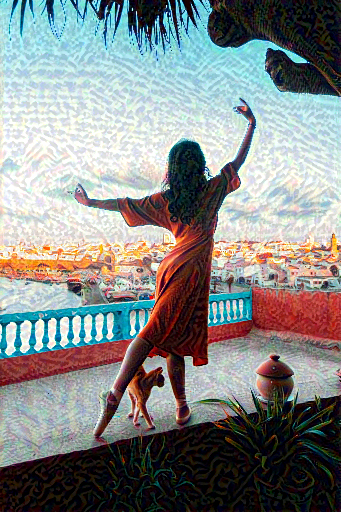

In [ ]:
train_step(image, opt)
train_step(image, opt)
train_step(image, opt)
tensor_to_image(image)


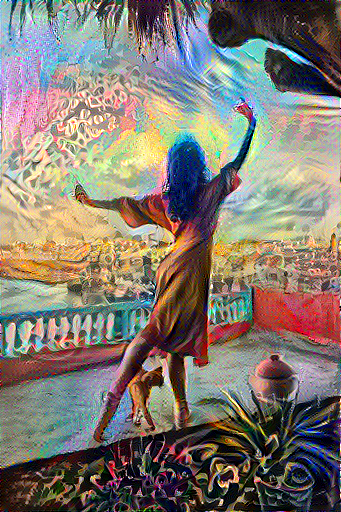

Train step: 1000
Total time: 6152.7


In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image, opt)  # Pass 'opt' to the train_step function
        print(".", end='', flush=True)

    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))
end = time.time()
print("Total time: {:.1f}".format(end-start))






